In [23]:
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt
from matplotlib import cm
import multiprocessing as mp
from stitch import stitch

In [24]:
# Assume Cobb-Douglas. Generalized later. 

# Household parameters
life = 80
S = 80
working = round(9 * S / 16)
beta_annual = .96
beta = beta_annual ** (life / S)
    
sigma = 3.0

theta_h = 0.3
theta_f = 0.45

nvec_h = np.array([1.0] * working + [0.2] * (S - working))
nvec_f = np.array([1.0] * working + [0.2] * (S - working))

L_h = np.sum(nvec_h)
L_f = np.sum(nvec_f)

# Firm parameters
alpha_h = 0.4
alpha_f = 0.35

Z_h = 1.1
Z_f = 1.0

gamma_h = 0.4
gamma_f = 0.35

delta_annual_h = 0.07
delta_h = 1 - ((1 - delta_annual_h) ** (life / S))

delta_annual_f = 0.05
delta_f = 1 - ((1 - delta_annual_f) ** (life / S))

# SS parameters
SS_tol = 1e-13
xi = 0.6

In [25]:
@stitch(lambda cvec, sigma: -sigma / (cvec ** (1 + sigma)), (0, None), 1e-10)
def get_MUvec(cvec, sigma):
    return 1 / (cvec ** sigma)

@stitch(lambda x, gamma: gamma / (x ** (1 - gamma)), (0, None), 1e-10)
def root(x, gamma):
    return x ** gamma

def aggregate(P_1, P_2, e, theta):
    constant = ((1 - theta) ** (1 - theta)) * (theta ** theta)
    return (1 / constant) * root(P_1, (1 - theta)) * root((e * P_2), theta)

def get_K(P, r, L, Z, gamma, delta):
    return root(gamma * Z * P * root(L, (1 - gamma)) / (r + delta), 1 / (1 - gamma))

def get_w(P, K, L, Z, gamma):
    return (1 - gamma) * Z * P * root(K / L, gamma)

In [26]:
def get_cvec(Pvec, rvec, wvec, bvec, S, nvec, b_init=0):
    extended_bvec = np.zeros(S + 1)
    if b_init:
        extended_bvec[0] = b_init
    extended_bvec[1:-1] = bvec
    cvec = (nvec * wvec + (1 + rvec) * extended_bvec[:-1] - extended_bvec[1:]) / Pvec
    return cvec

def bvec_error(bvec, *args):
    P, r, w, S, beta, sigma, nvec = args
    
    cvec = get_cvec(P, r, w, bvec, S, nvec)
    
    MUvec = get_MUvec(cvec, sigma)
    
    error = MUvec[:-1] - beta * (1 + r) * MUvec[1:]
    
    return error

In [27]:
def prices_error(prices, *args):
    P_h, P_f, r_h, r_f = prices
    cvec_h, cvec_f, bvec_h, bvec_f, alpha_h, alpha_f = args
    
    e = (1 + r_f) / (1 + r_h)
    
    r = aggregate(r_h, r_f, 1 / e, alpha_h)
    r_star = aggregate(r_f, r_h, e, alpha_f)
    
    #???

In [28]:
def get_SS(HH_params, F_params, SS_params, guess):
    S, beta, sigma, theta_h, theta_f, nvec_h, nvec_f, L_h, L_f = HH_params
    Z_h, Z_f, gamma_h, gamma_f, delta_h, delta_f = F_params
    SS_tol, xi = SS_params
    P_h, P_f, r_h, r_f = guess
    iteration = 1
    
    e = (1 + r_f) / (1 + r_h)
    
    P = aggregate(P_h, P_f, 1 / e, theta_h)
    P_star = aggregate(P_f, P_h, e, theta_f)
    
    r = aggregate(r_h, r_f, 1 / e, alpha_h)
    r_star = aggregate(r_f, r_h, e, alpha_f)
    
    K_h = get_K(P_h, r, L_h, Z_h, gamma_h, delta_h)
    w_h = get_w(P_h, K_h, L_h, Z_h, gamma_h)
    
    K_f = get_K(P_f, r_star, L_f, Z_f, gamma_f, delta_f)
    w_f = get_w(P_f, K_f, L_f, Z_f, gamma_f)
    
    # Solve for savings using Euler Equations
    bvec_h_guess = 0.01 * np.ones(S - 1)
    bvec_h_args = (P, r_h, w_h, S, beta, sigma, nvec_h)
    bvec_h_result = opt.root(bvec_error, bvec_h_guess, args=bvec_h_args, tol=SS_tol)
    if not bvec_h_result.success:
        print("Root finder for bvec_h failed on iteration {}".format(iteration))
        print(bvec_h_result)
    else:
        bvec_h = bvec_h_result.x
    
    bvec_f_guess = 0.01 * np.ones(S - 1)
    bvec_f_args = (P_star, r_f, w_f, S, beta, sigma, nvec_f)
    bvec_f_result = opt.root(bvec_error, bvec_f_guess, args=bvec_f_args, tol=SS_tol)
    if not bvec_f_result.success:
        print("Root finder for bvec_f failed on iteration {}".format(iteration))
        print(bvec_f_result)
    else:
        bvec_f = bvec_f_result.x
    
    cvec_h = get_cvec(P, r_h, w_h, bvec_h, S, nvec_h)
    cvec_f = get_cvec(P, r_f, w_f, bvec_f, S, nvec_f)
    
    plt.figure(figsize=(12, 9))
    plt.plot(bvec_h)
    plt.plot(bvec_f)
    plt.show()

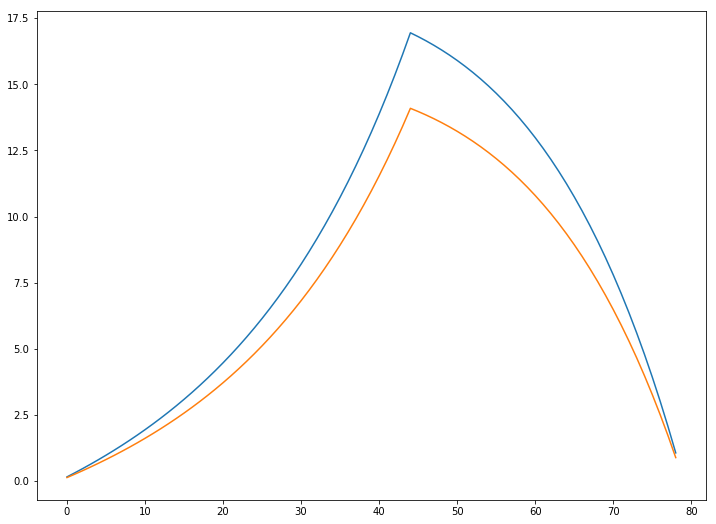

In [29]:
HH_params = (S, beta, sigma, theta_h, theta_f, nvec_h, nvec_f, L_h, L_f)
F_params = (Z_h, Z_f, gamma_h, gamma_f, delta_h, delta_f)
SS_params = (SS_tol, xi)
guess = (1, 1, 0.05, 0.05)
get_SS(HH_params, F_params, SS_params, guess)